# AdaBoost

### Name: Ronald Davi Rodrigues Pereira
### Student ID: 2019711249

In this project, we will implement the [Adaptative Boosting model (AdaBoost)](https://www.sciencedirect.com/science/article/pii/S002200009791504X) for the [Tic-Tac-Toe UCI Machine Learning Repository dataset](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame).

This dataset contains all possible Tic-Tac-Toe games possibilities and its outcome for a given player using the 'x' mark. The label of this dataset indicates if 'x' won or lost.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from itertools import product
from sklearn.model_selection import StratifiedKFold

SEED = 1212

## Reading the dataset as CSV file

1. top-left-square: {x,o,b} -> 'tl'
2. top-middle-square: {x,o,b} -> 'tm'
3. top-right-square: {x,o,b} -> 'tr'
4. middle-left-square: {x,o,b} -> 'ml'
5. middle-middle-square: {x,o,b} -> 'mm'
6. middle-right-square: {x,o,b} -> 'mr'
7. bottom-left-square: {x,o,b} -> 'bl'
8. bottom-middle-square: {x,o,b} -> 'bm'
9. bottom-right-square: {x,o,b} -> 'br'
10. Class: {positive,negative} -> 'label'

In [2]:
tic_tac_toe_df = pd.read_csv('data/tic-tac-toe.data', header=None)
tic_tac_toe_df.columns = ['tl', 'tm', 'tr', 'ml', 'mm', 'mr', 'bl', 'bm', 'br', 'label']
tic_tac_toe_df.head()

,tl,tm,tr,ml,mm,mr,bl,bm,br,label
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


## Dataset Preprocessing

The objective here is to convert all symbols in the Tic-Tac-Toe dataset to numerical and boolean values.

Features:

- The 'x' is replaced by +1
- The 'o' is replaced by -1
- The 'b' is replaced by 0

Labels:

- The positive label is replaced by +1
- The negative label is replaced by -1

In [3]:
replace_dict = {'x': 1, 'o':-1, 'b':0, 'positive':1, 'negative': -1}
tic_tac_toe_df.replace(to_replace=replace_dict, inplace=True)
tic_tac_toe_df.head()

,tl,tm,tr,ml,mm,mr,bl,bm,br,label
0,1,1,1,1,-1,-1,1,-1,-1,1
1,1,1,1,1,-1,-1,-1,1,-1,1
2,1,1,1,1,-1,-1,-1,-1,1,1
3,1,1,1,1,-1,-1,-1,0,0,1
4,1,1,1,1,-1,-1,0,-1,0,1


## AdaBoost model

Each method of the class is explained in a docstring below its definition.

In [4]:
class AdaBoost():
    def __init__(self, train_df: pd.DataFrame, validation_df: pd.DataFrame):
        """
        AdaBoost model class.
        
        Args:
            train_df (pd.DataFrame): Train dataset.
            validation_df (pd.DataFrame): Validation dataset.
        """

        self.train = train_df
        self.validation = validation_df
        self.weights = np.ones(self.train.shape[0]) * 1/self.train.shape[0]

    def classify_stump(self, stump: tuple, row: pd.Series) -> int:
        """
        Classifies a dataset row given a stump.

        Args:
            stump (tuple[str, bool, bool, bool, int]): Stump information.
            row (pd.Series): Dataset row to classify.
        
        Returns:
            int: Classification label.
        """

        feature_value = row[stump[0]]
        
        if ((feature_value == replace_dict['x'] and stump[1]) or
            (feature_value == replace_dict['b'] and stump[2]) or
            (feature_value == replace_dict['o'] and stump[3])):
            return stump[4]
        
        return -stump[4]

    def find_best_stump(self) -> tuple:
        """
        Finds the best stump of a given round.
        The definition of a stump is given by: (position, is_x, is_b, is_o, label).

        Returns:
            tuple[float, tuple[str, bool, bool, bool, int]]: alpha and best stump representation.
        """

        best_stump = tuple()
        best_empirical_error = float('inf')

        positions = [position for position in self.train.columns[:-1]]
        is_x = [False, True]
        is_b = [False, True]
        is_o = [False, True]
        label = [-1, 1]

        stumps = product(positions, is_x, is_b, is_o, label)

        for stump in stumps:
            current_error = 0
            for i, row in self.train.iterrows():
                if self.classify_stump(stump, row) != row['label']:
                    current_error += self.weights[i]
            if current_error < best_empirical_error:
                best_empirical_error = current_error
                best_stump = stump

        try:
            alpha = (1/2) * np.log2((1-best_empirical_error) / best_empirical_error)
        except ZeroDivisionError:
            alpha = 1.0

        return alpha, best_stump

    def update_weights(self, alpha: float, stump: tuple):
        """
        Updates the weights to next round based on actual round.

        Args:
            alpha (float): Alpha that indicates the importance of that stump.
            stump (tuple[str, bool, bool, bool, int]): Stump to update.
        """

        z = np.sum(self.weights)
        for i, row in self.train.iterrows():
            self.weights[i] *= np.exp(-alpha * self.classify_stump(stump, row) * row['label']) / z

    def predict(self, data: pd.DataFrame) -> list:
        """
        Predicts all labels for a given dataset.tuple

        Args:
            data (pd.DataFrame): Dataset to predict.

        Returns:
            list: List of predictions.
        """

        predictions = []
        for n in range(data.shape[0]):
            prediction = 0
            for i in range(len(self.stumps)):
                prediction += self.alphas[i] * self.classify_stump(self.stumps[i], data.loc[n])
            predictions.append(-1 if prediction < 0 else 1)

        return predictions

    def error_score(self, use_train: bool=True) -> float:
        """
        Calculates the classification error score.

        Args:
            use_train (bool): Whether to use train or validation set. Defaults to True.

        Returns:
            float: Error score in that dataset.
        """

        data = self.train if use_train else self.validation
        predictions = self.predict(data)
        errors = 0
        for i, row in data.iterrows():
            if predictions[i] != row['label']:
                errors += 1
        return errors / data.shape[0]

    def fit(self, n_rounds:int=100, early_stopping_rounds:int=10) -> tuple:
        """
        Fit method for AdaBoost.

        Args:
            n_rounds (int): Number of rounds (stumps). Defaults to 100.
            early_stopping_rounds (int): Number of rounds without improvement to avoid overfitting. Defaults to 10.
        
        Returns:
            Tuple[list, list]: Train error values and Validation error values.
        """

        self.alphas = []
        self.stumps = []
        train_errors = []
        validation_errors = []
        train_best_error = 1
        validation_best_error = 1
        no_improvement_rounds = 0

        for n in range(n_rounds):
            alpha, stump = self.find_best_stump()
            self.alphas.append(alpha)
            self.stumps.append(stump)
            self.update_weights(alpha, stump)

            train_error = self.error_score()
            train_errors.append(train_error)

            validation_error = self.error_score(use_train=False)
            validation_errors.append(validation_error)

            if validation_error >= validation_best_error:
                no_improvement_rounds += 1
            else:
                train_best_error = train_error
                validation_best_error = validation_error
                no_improvement_rounds = 0

            if no_improvement_rounds >= early_stopping_rounds:
                print('-'*20 + ' Early Stopping limit reached ' + '-'*20)
                print(f'[Best Round {n-no_improvement_rounds+1:04d}] Train_Error: {train_best_error:.5f} Validation_Error: {validation_best_error:.5f}')
                break

            print(f'[Round {n+1:04d}] Train_Error: {train_error:.5f} Validation_Error: {validation_error:.5f}')

        return train_errors, validation_errors

## Stratified 5-fold Cross Validation

For a better model evaluation, a Stratifies 5-fold Cross Validation is used.

The stratification is used to avoid distant datasets in label distribution, making it more accurate to a real error.

In [5]:
train_kfold_errors = []
validation_kfold_errors = []

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

for fold, (train_index, validation_index) in enumerate(skf.split(np.zeros(tic_tac_toe_df.shape[0]), tic_tac_toe_df['label'])):
    print('-'*30 + f' Fold {fold+1} ' + '-'*30)
    train_dataset = tic_tac_toe_df.loc[train_index].reset_index(drop=True)
    validation_dataset = tic_tac_toe_df.loc[validation_index].reset_index(drop=True)

    ada_boost = AdaBoost(train_dataset, validation_dataset)
    train_errors, validation_errors = ada_boost.fit(n_rounds=100, early_stopping_rounds=10)
    train_kfold_errors.append(train_errors)
    validation_kfold_errors.append(validation_errors)

------------------------------ Fold 1 ------------------------------
[Round 0001] Train_Error: 0.30287 Validation_Error: 0.29167
[Round 0002] Train_Error: 0.30287 Validation_Error: 0.29167
[Round 0003] Train_Error: 0.36684 Validation_Error: 0.33854
[Round 0004] Train_Error: 0.29765 Validation_Error: 0.30729
[Round 0005] Train_Error: 0.27285 Validation_Error: 0.26042
[Round 0006] Train_Error: 0.32376 Validation_Error: 0.27604
[Round 0007] Train_Error: 0.25457 Validation_Error: 0.28646
[Round 0008] Train_Error: 0.25718 Validation_Error: 0.25000
[Round 0009] Train_Error: 0.23107 Validation_Error: 0.25521
[Round 0010] Train_Error: 0.26110 Validation_Error: 0.29167
[Round 0011] Train_Error: 0.20888 Validation_Error: 0.25521
[Round 0012] Train_Error: 0.25326 Validation_Error: 0.23438
[Round 0013] Train_Error: 0.18538 Validation_Error: 0.13021
[Round 0014] Train_Error: 0.23890 Validation_Error: 0.21354
[Round 0015] Train_Error: 0.18538 Validation_Error: 0.15625
[Round 0016] Train_Error: 0.223

## Training and Validation Error Plots

In order to make it easier to see the results of the model, we plot and aggregate all results from the previous stratified 5-fold cross validation.

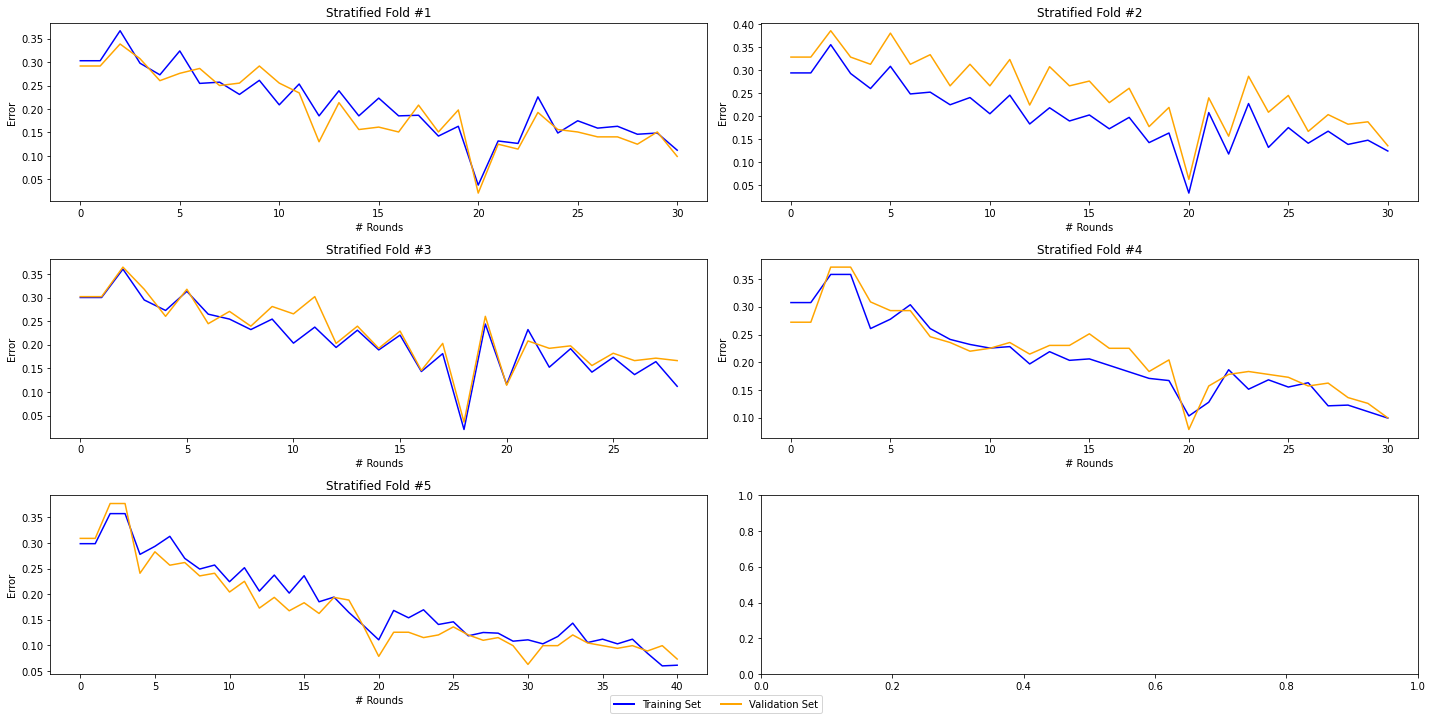

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))

fold_to_axs = {0: axs[0, 0], 1: axs[0, 1], 2: axs[1, 0], 3: axs[1, 1], 4: axs[2, 0]}

for fold in range(n_splits):
    fold_to_axs[fold].plot(list(range(len(train_kfold_errors[fold]))), train_kfold_errors[fold], color='blue')
    fold_to_axs[fold].plot(list(range(len(validation_kfold_errors[fold]))), validation_kfold_errors[fold], color='orange')
    fold_to_axs[fold].set_title(f'Stratified Fold #{fold+1}')
    fold_to_axs[fold].set_xlabel('# Rounds')
    fold_to_axs[fold].set_ylabel('Error')

legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Training Set'),
                   Line2D([0], [0], color='orange', lw=2, label='Validation Set')]
fig.legend(handles=legend_elements, loc="lower center", ncol=2)
fig.tight_layout()
plt.show()

In [7]:
n_rounds = [21, 21, 19, 21, 31]
train_best_errors = [0.03786, 0.03264, 0.02089, 0.10300, 0.11082]
validation_best_errors = [0.02083, 0.06250, 0.03646, 0.07853, 0.06283]

print(f'Number of Rounds for each Fold: {n_rounds}')
print(f'Best Training Error for each Fold: {train_best_errors}')
print(f'Best Validation Error for each Fold: {validation_best_errors}')
print()
print(f'Average Number of Rounds: {np.mean(n_rounds)} +/- {np.std(n_rounds)}')
print(f'Average Training Error: {np.mean(train_best_errors)} +/- {np.std(train_best_errors)}')
print(f'Average Validation Error: {np.mean(validation_best_errors)} +/- {np.std(validation_best_errors)}')
print()
print(f'Average Training Accuracy: {1-np.mean(train_best_errors)} +/- {np.std(train_best_errors)}')
print(f'Average Validation Accuracy: {1-np.mean(validation_best_errors)} +/- {np.std(validation_best_errors)}')


Number of Rounds for each Fold: [21, 21, 19, 21, 31]
Best Training Error for each Fold: [0.03786, 0.03264, 0.02089, 0.103, 0.11082]
Best Validation Error for each Fold: [0.02083, 0.0625, 0.03646, 0.07853, 0.06283]

Average Number of Rounds: 22.6 +/- 4.2708313008125245
Average Training Error: 0.061042 +/- 0.03793305914370736
Average Validation Error: 0.05223 +/- 0.020708335519785268

Average Training Accuracy: 0.938958 +/- 0.03793305914370736
Average Validation Accuracy: 0.94777 +/- 0.020708335519785268


## Conclusion

At an average, the AdaBoost model uses $22.6$ stumps to achieve its peak accuracy, that is $\approx 95\% \pm 2 \%$ in the validation set.

As we can also see, the standard deviation between the metrics for each fold is very small ($\approx 4\%$ in training set and $\approx 2\%$ in validation set),
showing that our 5-fold cross validation makes a good estimation of the model results.